# Trying Data Augmentation strategies

In [50]:
import os
import sys
import time
from pathlib import Path
module_path = os.path.abspath('../utils')
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib 
from deepbrain import Extractor
import ants

# from skull_stripping_ants.s3 import *
# from deepbrain_skull_strip import deep_brain_skull_stripping
from base_mri import list_available_images, delete_useless_images, set_env_variables, load_mri, save_mri, create_file_name_from_path
from antspy_registration import register_image_with_atlas
# from crop_mri import crop_mri_at_center
# from standardize_mri import clip_and_normalize_mri

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.listdir("/home/lucasthim1/alzheimer_data/preprocessed_images_20210321/")[:10]

['ADNI_009_S_0842_MR_MT1__GradWarp__N3m_Br_20160607213047206_S264696_I727838.npz',
 'ADNI_072_S_2037_MR_MT1__N3m_Br_20110307133517340_S90266_I222683.npz',
 'ADNI_009_S_5037_MR_MT1__GradWarp__N3m_Br_20130207114609575_S180207_I358355.npz',
 'ADNI_006_S_0731_MR_MT1__N3m_Br_20131113122816070_S204901_I398108.npz',
 'ADNI_012_S_5213_MR_MT1__N3m_Br_20130801191233337_S195995_I384096.npz',
 'ADNI_072_S_4131_MR_MT1__GradWarp__N3m_Br_20110804073741464_S115986_I248648.npz',
 'ADNI_013_S_5137_MR_MT1__N3m_Br_20130501084308913_S187580_I369614.npz',
 'ADNI_018_S_4313_MR_MT1__N3m_Br_20111206110004548_S131107_I270069.npz',
 'ADNI_006_S_4150_MR_MT1__N3m_Br_20110816095158391_S117925_I250657.npz',
 'ADNI_128_S_4745_MR_MT1__GradWarp__N3m_Br_20120626143852286_S153274_I312672.npz']

In [44]:
input_path = "/home/lucasthim1/alzheimer_data/preprocessed_images_20210321/ADNI_014_S_4615_MR_MT1__GradWarp__N3m_Br_20120405104659318_S145232_I295883.npz"
input_path2 = "/home/lucasthim1/alzheimer_data/preprocessed_images_20210321/ADNI_010_S_4135_MR_MT1__N3m_Br_20110804075757773_S116397_I248671.npz"
input_path3 = "/home/lucasthim1/alzheimer_data/preprocessed_images_20210321/ADNI_072_S_4131_MR_MT1__GradWarp__N3m_Br_20110804073741464_S115986_I248648.npz"
output_path = "/home/lucasthim1/alzheimer_data/test/"
atlas_path = '/home/lucasthim1/alzheimer_data/Atlas/atlas_t1.nii'

sample = load_mri(input_path,as_ants=False)
sample2 = load_mri(input_path2,as_ants=False)
sample3 = load_mri(input_path3,as_ants=False)

In [62]:
def show_slices(img):
    img_size = img.shape
    img.plot(axis =0,figsize=2,nslices=6,title=f'Image size: {img_size}')
    img.plot(axis =1,figsize=2,nslices=6,title=f'Image size: {img_size}')
    img.plot(axis =2,figsize=2,nslices=6,title=f'Image size: {img_size}')

# def show_brain_center_slice(img: np.memmap):
#     slice_0 = img[int(img.shape[0]/2), :, :]
#     slice_1 = img[:, int(img.shape[1]/2), :]
#     slice_2 = img[:, :, int(img.shape[2]/2)]
#     show_slices([slice_0, slice_1, slice_2],img)


/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



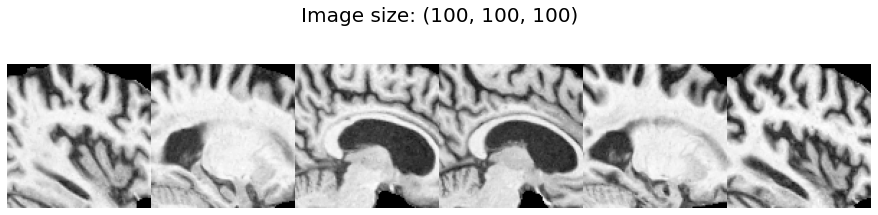

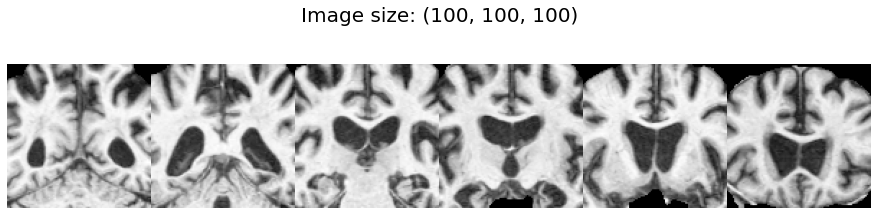

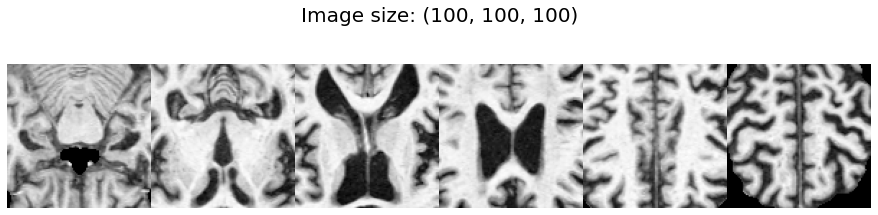

In [14]:
show_slices(sample)

/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



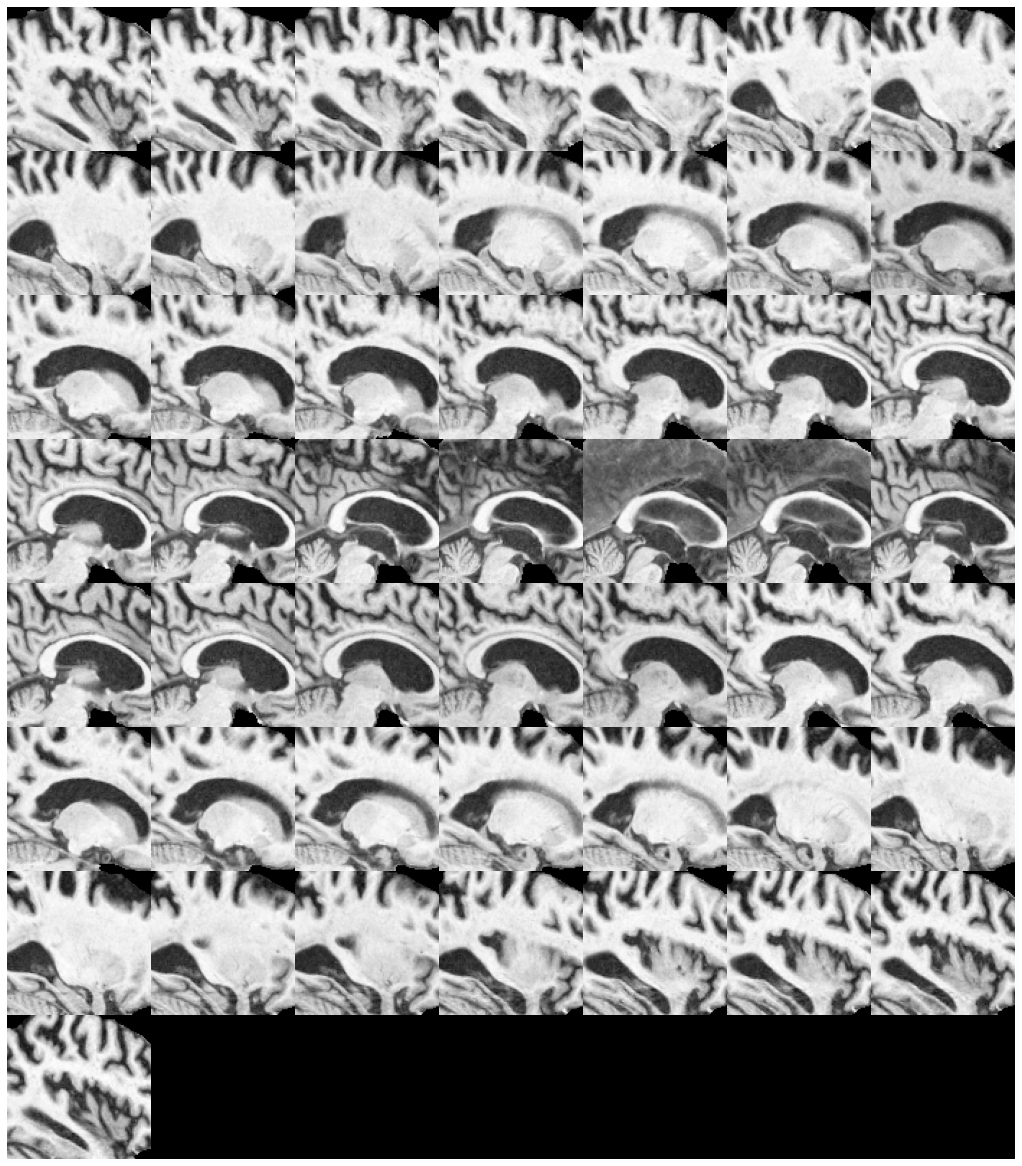

In [15]:
sample.plot(axis =0,figsize=2,nslices=50)


/home/lucasthim1/miniconda3/envs/deepbrain/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



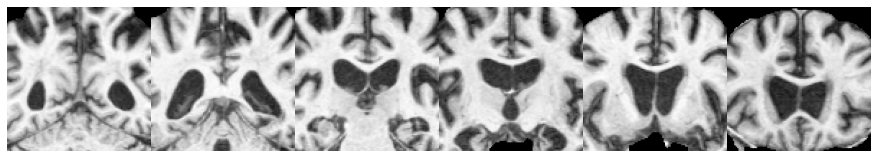

In [20]:
sample.plot(axis =1,figsize=2,nslices=6)


# Applying Simple Data Augmentation Processes

1. 90º Rotation
2. 180º Rotation
3. 270º Rotation 
4. Horizontal Flipping
5. Vertical Flipping

Axis:
- 0 = sagittal (side of the head)
- 1 = coronal (front/back of the head)
- 2 = axial (top/bottom of the head)

In [163]:
def show_slices(slices,image_orientation = 'Coronal'):
    """ Function to display 2D MRI"""
    fig, axes = plt.subplots(1, len(slices))
    if len(slices) > 4:
        fig.set_size_inches(20,8)
    else:
        fig.set_size_inches(15,8)
        
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
    plt.suptitle(f"{image_orientation} image - size = {slices[0].shape}",fontsize=20,y=0.75)
    plt.tight_layout()
    plt.show()

In [182]:
slice_point = 30
image_orientation = 'coronal'
operation_type = 'rot_90'
image = load_mri(input_path,as_ants=False)
image_2d = image[slice_point,:,:]

In [183]:
# new_output_path = input_path.split('.')[0] + '_' + image_orientation + '_' + str(slice_point) + '_rot_90.' + input_path.split('.')[1]
output_path + create_file_name_from_path(input_path)+ '_' + image_orientation + '_' + str(slice_point) + '_' + operation_type 

'/home/lucasthim1/alzheimer_data/test/ADNI_014_S_4615_MR_MT1__GradWarp__N3m_Br_20120405104659318_S145232_I295883_coronal_30_rot_90'

In [165]:
img_rot_90 = np.rot90(image_2d, k=1, axes=(1,0))
img_rot_180 = np.rot90(image_2d, k=2, axes=(1,0))
img_rot_270 = np.rot90(image_2d, k=3, axes=(1,0))
img_flip_horizonal = np.fliplr(image_2d)
img_flip_vertical = np.flipud(image_2d)
# TODO: investigate if all these processes in sequence do not mess with the original image

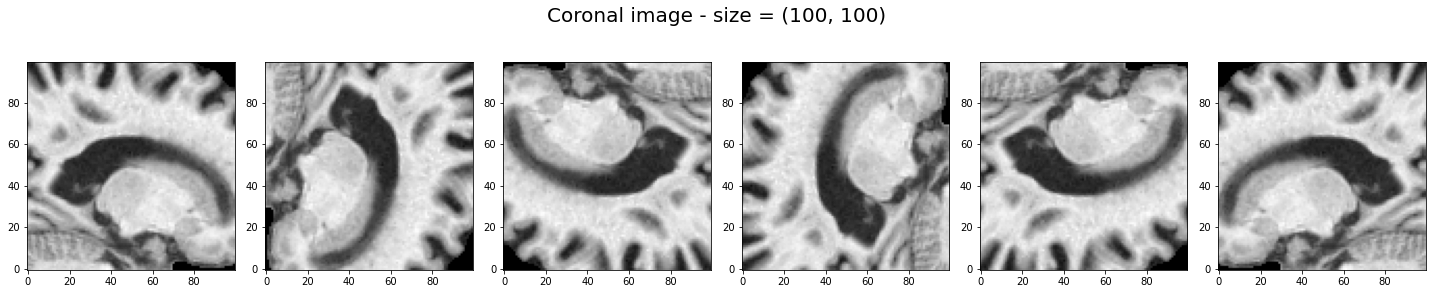

In [166]:
show_slices([image_2d,img_rot_90,img_rot_180,img_rot_270,img_flip_horizonal,img_flip_vertical])